## ATAC + MULTIOME MALES

### Convert to Seurat object for CICERO

In [1]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata


/opt/conda/envs/atac_env/lib/python3.8/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
import anndata2ri
anndata2ri.activate()
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.7.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
anndata2ri          1.0.6
backcall            0.2.0
cairo               1.20.0
cffi                1.14.4
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
highs_wrapper       NA
igraph              0.8.3
ipykernel           5.4.3
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.0
kiwisolver          1.3.1
legacy_api_wrap     1.2
leidenalg           0.8.3
llvmlite            0.35.0
markupsafe          1.1.1
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.52.0
numexpr             2.7.2
numpy               1.20.0
packaging           20.9
pandas              1.2.1
parso               0.8.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_res

In [5]:
print(anndata2ri.__version__)
print(anndata.__version__)

1.0.6
0.7.5


In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(Signac)
library(Seurat)
library(SeuratDisk)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)
library(ensembldb)
library(JASPAR2018)
library(TFBSTools)
library(patchwork)
library(universalmotif)
library(MotifDb)
library(TFBSTools)
library(patchwork)
library(chromVAR)
library(motifmatchr)

For future reference most packages were installed here: */tmp/RtmpGjkK1o/downloaded_packages/*

**Set directories**

In [8]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_apr2021/"
experiment_prefix = 'males_'

#### Convert the h5ad created with cisTopic into a Seurat object with peaks assay

In [14]:
ATAC_scanpy = sc.read_h5ad(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
ATAC_scanpy

AnnData object with n_obs × n_vars = 30276 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'Sertoli_WFDC2', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5', 'max', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'sex

In [10]:
ATAC_scanpy.X

<30276x232562 sparse matrix of type '<class 'numpy.float32'>'
	with 155575064 stored elements in Compressed Sparse Row format>

In [11]:
binary_raw = ATAC_scanpy.layers['binary_raw']
binary_raw

<30276x232562 sparse matrix of type '<class 'numpy.float32'>'
	with 155575064 stored elements in Compressed Sparse Row format>

In [12]:
binary_raw.shape

(30276, 232562)

Step 1: from sparse matrix (python format) to dgcMatrix (R format)

I found this function here: <https://github.com/theislab/anndata2ri/issues/8>

In [13]:
import numpy as np
from scipy import sparse

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.conversion import localconverter

ro.r("library(Matrix)")

def csr_to_dgc(csr):
    """Convert (and transpose) a csr matrix from python to a R dgCMatrix (not sure if type is consistent)
    """
    numeric = ro.r("as.numeric")
    with localconverter(ro.default_converter + ro.numpy2ri.converter):
        X = ro.r("sparseMatrix")(
            i=numeric(csr.indices),
            p=numeric(csr.indptr),
            x=numeric(csr.data),
            dims=list(csr.shape[::-1]),
            index1=False
        )
    return X

In [14]:
ATAC_R = csr_to_dgc(binary_raw)
ATAC_R

<rpy2.robjects.methods.RS4 object at 0x7fa232baf600> [RTYPES.S4SXP]
R classes: ('dgCMatrix',)

In [15]:
%%R -i ATAC_R -o ATAC_dgT

ATAC_dgT <- as(ATAC_R, "dgTMatrix")
print(dim(ATAC_dgT)) # Check the shape of the matrix 

[1] 232562  30276


Step 2: save metadata per cell and per peak and add colnames and rownames to the peak matrix

In [16]:
metadata_cell = ATAC_scanpy.obs
metadata_peak = ATAC_scanpy.var
layers = ATAC_scanpy.layers
reduction_cistopic = ATAC_scanpy.obsm['X_cistopic_28']
reduction_umap = ATAC_scanpy.obsm['X_umap']
reduction_harmony = ATAC_scanpy.obsm['X_harmony']

In [17]:
del ATAC_scanpy.obs['cellatac_clusters']

In [18]:
%%R -i ATAC_dgT -i metadata_cell -i metadata_peak 

rownames(ATAC_dgT) <- rownames(metadata_peak) # Add rownames to peak matrix
colnames(ATAC_dgT) <- rownames(metadata_cell) # Add colnames to peak matrix 

In [19]:
%%R 
print(head(rownames(ATAC_dgT)))
print(head(colnames(ATAC_dgT)))
print(names(ATAC_dgT))

[1] "chr1:816745-817435" "chr1:817739-818227" "chr1:826603-827799"
[4] "chr1:842634-843206" "chr1:868834-869156" "chr1:869371-870182"
[1] "01-AAACGAAAGCTGAGGT-1" "01-AAACGAACAATCATCG-1" "01-AAACTCGTCACCCGGA-1"
[4] "01-AAACTGCCAAGGGTAC-1" "01-AAACTGCGTGAATGTA-1" "01-AAACTGCGTTCAGTAC-1"
NULL


Step 3: build ChromatinAssay with peaks x cells matrix 

In [20]:
%%R -o chrom_assay 

 chrom_assay <- CreateChromatinAssay(
    counts = ATAC_dgT,
    sep = c(":", "-"),
    genome = "hg38",
    ranges = NULL,
 )
chrom_assay

ChromatinAssay data with 232562 features for 30276 cells
Variable features: 0 
Genome: hg38 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 0 


Step 4: build Seurat object from chromatin assay 

In [21]:
%%R -o ATAC_Seurat -i metadata_cell

ATAC_Seurat <- CreateSeuratObject(
    counts = chrom_assay,
    assay = "peaks",
    meta.data = metadata_cell,
  )
ATAC_Seurat

An object of class Seurat 
232562 features across 30276 samples within 1 assay 
Active assay: peaks (232562 features, 0 variable features)


In [22]:
%%R 
print(table(ATAC_Seurat@meta.data$individual))
print(table(ATAC_Seurat@meta.data$leiden))


 Hrv3 Hrv10 Hrv15 Hrv17 Hrv18 Hrv21 Hrv40 
 1061  2822  3383  8302  4372  5143  5193 

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7342 4298 3975 3189 2387 1238 1147  983  894  890  870  824  508  438  375  323 
  16   17   18 
 304  222   69 


Step 5: Add dimensionality reductions to Seurat object 

In [23]:
%%R -i reduction_cistopic -i metadata_cell -o reduction_cistopic_2 

reduction_cistopic_2 <- data.matrix(reduction_cistopic)
key <- "cisTopic_"
colnames(reduction_cistopic_2) <- paste0(key, 1:ncol(x = reduction_cistopic_2))
rownames(reduction_cistopic_2) <- rownames(metadata_cell)
#print(head(reduction_cistopic_2))

In [24]:
%%R -i reduction_umap -i metadata_cell -o reduction_umap_2 

reduction_umap_2 <- data.matrix(reduction_umap)
key2 <- "UMAP_"
colnames(reduction_umap_2) <- paste0(key2, 1:ncol(x = reduction_umap_2))
rownames(reduction_umap_2) <- rownames(metadata_cell)
#print(head(reduction_umap_2))

In [25]:
%%R -i reduction_harmony -i metadata_cell -o reduction_harmony_2 

reduction_harmony_2 <- data.matrix(reduction_harmony)
key3 <- "Harmony_"
colnames(reduction_harmony_2) <- paste0(key3, 1:ncol(x = reduction_harmony_2))
rownames(reduction_harmony_2) <- rownames(metadata_cell)
#print(head(reduction_harmony_2))

In [26]:
%%R 

ATAC_Seurat@reductions$cisTopics <- CreateDimReducObject(embeddings = reduction_cistopic_2, assay = "peaks")
ATAC_Seurat@reductions$umap <- CreateDimReducObject(embeddings = reduction_umap_2, assay = "peaks")
ATAC_Seurat@reductions$harmony <- CreateDimReducObject(embeddings = reduction_harmony_2, assay = "peaks")
ATAC_Seurat

An object of class Seurat 
232562 features across 30276 samples within 1 assay 
Active assay: peaks (232562 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


### Save RDS object of males 

In [27]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat, file = paste0(outdir, experiment_prefix, "_full.rds"))

In [16]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat <- readRDS(file = paste0(outdir, experiment_prefix, "_full.rds"))

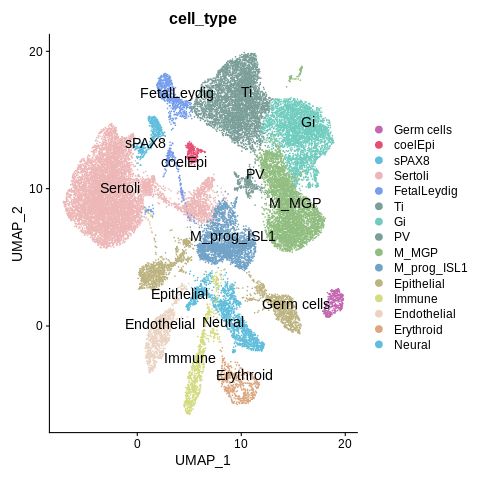

In [28]:
%%R 

gonads_colors = c('#c466b0','#e64e74',  '#60bddb', '#edb7b7', '#779eed', '#7b9e99',  '#70ccbe', 
               '#7b9e99', '#91bd80', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#edb7b7', '#d9abb7','#aad3f2', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

DimPlot(object = ATAC_Seurat, group.by = "cell_type", label = TRUE, repel = TRUE,
        label.size = 5, cols = gonads_colors)

## TF motifs with ChromVar

In [29]:
%%R -o pfm

# Get a list of motif position frequency matrices from the JASPAR, HOCOMOCO, HOMER and SwissRegulon databases
pfm <- getMatrixSet(
  x = JASPAR2018,
  opts = list(species = 9606, all_versions = FALSE)
)

tf_motif_hoco=subset(MotifDb, organism=='Hsapiens' & dataSource=='HOCOMOCOv10')
pfmHoco = convert_motifs(tf_motif_hoco, 'TFBSTools-PWMatrix')
pfmHoco_names =  sapply(pfmHoco, function(x) x@ID)
names(tf_motif_hoco) = pfmHoco_names
for (i in 1:length(pfmHoco) ){
    # Convert into a PCM
    x = t(pfmHoco[[i]]@profileMatrix) - apply(pfmHoco[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHoco[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHoco[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmHoco_names[i]]] <- pfmHoco[[i]]
}
# add data from SwissRegulon                       
tf_motif_SwissRegulon=subset(MotifDb, organism=='Hsapiens' & dataSource=='SwissRegulon')
pfmSwissRegulon = convert_motifs(tf_motif_SwissRegulon, 'TFBSTools-PWMatrix')
pfmSwissRegulon_names =  sapply(pfmSwissRegulon, function(x) x@ID)
names(tf_motif_SwissRegulon) = pfmSwissRegulon_names
for (i in 1:length(pfmSwissRegulon) ){
    # Convert into a PCM
    x = t(pfmSwissRegulon[[i]]@profileMatrix) - apply(pfmSwissRegulon[[i]]@profileMatrix, 2, min) # normalize per column
    pfmSwissRegulon[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmSwissRegulon[[i]]@profileMatrix) <- 'integer'
    pfm[[pfmSwissRegulon_names[i]]] <- pfmSwissRegulon[[i]]
}


# add data from HOMER                       
tf_motif_HOMER=subset(MotifDb, dataSource=='HOMER')
pfmHOMER = convert_motifs(tf_motif_HOMER, 'TFBSTools-PWMatrix')
pfmHOMER_names =  sapply(pfmHOMER, function(x) x@ID)
names(pfmHOMER) = paste0( sapply( strsplit(pfmHOMER_names, '\\('), head, 1), '.HOMER')
#print(names(pfmHOMER))
names(pfmHOMER)[93] = "FOXL2.HOMER"
 
pfmHOMER = pfmHOMER[ grep('[a-z]',  names(pfmHOMER), invert = T) ] # remove non-human (lowercase)
#print(names(pfmHOMER))

for (i in 1:length(pfmHOMER) ){
    # Convert into a PCM
    x = t(pfmHOMER[[i]]@profileMatrix) - apply(pfmHOMER[[i]]@profileMatrix, 2, min) # normalize per column
    pfmHOMER[[i]]@profileMatrix = round(t(x / apply(x, 1, max))*100) # mulitply x100 and round
    class(pfmHOMER[[i]]@profileMatrix) <- 'integer'
    pfmHOMER[[i]]@name = gsub('.HOMER', '', names(pfmHOMER)[i])
    pfm[[names(pfmHOMER)[i]]] <- pfmHOMER[[i]]
}


# Add name in id
idx =  grep('^MA', names(pfm) )
for (i in idx ){
    pfm[[i]]@ID = paste0(pfm[[i]]@name, '.', pfm[[i]]@ID)
    names(pfm)[i] = pfm[[i]]@ID
}

# remove pcm with NAs
pfm = pfm[ ! sapply(pfm, function(x) any(is.na(x@profileMatrix))) ]

length(pfm)
table(unlist(sapply(pfm, function(x) x@tags$dataSource)))

[1] 638 147 683


#### Add motifs

In [30]:
%%R -o ATAC_Seurat_withMotifs

ATAC_Seurat_withMotifs <- AddMotifs(object = ATAC_Seurat, 
                         genome= BSgenome.Hsapiens.UCSC.hg38, 
                         pfm = pfm, 
                         assay = "peaks", 
                         verbose = TRUE)

ATAC_Seurat_withMotifs

An object of class Seurat 
232562 features across 30276 samples within 1 assay 
Active assay: peaks (232562 features, 0 variable features)
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### Compute per-cell motif activity scores with chromVar

In [31]:
%%R -o ATAC_Seurat_withChromVar

library(BiocParallel)
register(SerialParam())
ATAC_Seurat_withChromVar <- RunChromVAR(
  object = ATAC_Seurat_withMotifs,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  assay="peaks"
)
ATAC_Seurat_withChromVar

An object of class Seurat 
234482 features across 30276 samples within 2 assays 
Active assay: peaks (232562 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


In [32]:
%%R -i outdir -i experiment_prefix

saveRDS(ATAC_Seurat_withChromVar, file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))

In [9]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(file = paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
ATAC_Seurat_withChromVar

An object of class Seurat 
234482 features across 30276 samples within 2 assays 
Active assay: peaks (232562 features, 0 variable features)
 1 other assay present: chromvar
 3 dimensional reductions calculated: cisTopics, umap, harmony


#### z-score per cell type

In [34]:
%%R -i pfm -o motif2names

library(dplyr) 
motif2names <- lapply(pfm, function(x) x@name)
names(motif2names) <- sapply(pfm, function(x) x@ID) %>% gsub('_', '-', .)

In [35]:
%%R 

DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 

In [36]:
%%R 

Idents(ATAC_Seurat_withChromVar) <- ATAC_Seurat_withChromVar@meta.data$cell_type
print(table(Idents(ATAC_Seurat_withChromVar)))


 Germ cells     coelEpi       sPAX8     Sertoli FetalLeydig          Ti 
        323         222         438        8580         890        4298 
         Gi          PV       M_MGP M_prog_ISL1  Epithelial      Immune 
       3189         304        4044        2387        1853         824 
Endothelial   Erythroid      Neural 
        894         508        1522 


In [37]:
%%R -i outdir -o all_da_peaks

all_da_peaks = FindAllMarkers(ATAC_Seurat_withChromVar, test.use = 'LR', verbose = T, only.pos = F, random.seed = 1, logfc.threshold = 0, min.pct = 0, return.thresh = 1)
write.csv(all_da_peaks, file = paste0(outdir, 'TFs/DARs/all_DA_peaks_LR.csv'))

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~16m 53s       |++                                                | 2 % ~19m 13s       |++                                                | 3 % ~25m 20s       |+++                                               | 4 % ~22m 40s       |+++                                               | 5 % ~20m 44s       |++++                                              | 6 % ~18m 49s       |++++                                              | 7 % ~18m 30s       |+++++                                             | 8 % ~17m 57s       |+++++                                             | 9 % ~17m 37s       |++++++                                            | 10% ~17m 34s       |++++++                                            | 11% ~19m 38s       |+++++++                                           | 12% ~21m 01s       |+++++++                                           | 14% ~20m 

In [10]:
%%R -i outdir -i experiment_prefix

ATAC_Seurat_withChromVar <- readRDS(paste0(outdir, experiment_prefix, "_chromVar_binary.rds"))
DefaultAssay(ATAC_Seurat_withChromVar) <- "chromvar" # Change default assay 
ATAC_Seurat_withChromVar

An object of class Seurat 
234482 features across 30276 samples within 2 assays 
Active assay: chromvar (1920 features, 0 variable features)
 1 other assay present: peaks
 3 dimensional reductions calculated: cisTopics, umap, harmony


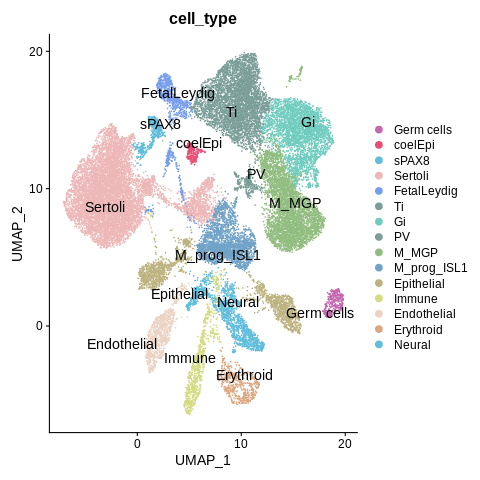

In [42]:
%%R 

gonads_colors = c('#c466b0','#e64e74',  '#60bddb', '#edb7b7', '#779eed', '#7b9e99',  '#70ccbe', 
               '#7b9e99', '#91bd80', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#edb7b7', '#d9abb7','#aad3f2', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb')

DimPlot(object = ATAC_Seurat_withChromVar, group.by = "cell_type", label = TRUE, repel = TRUE,
        label.size = 5, cols = gonads_colors)

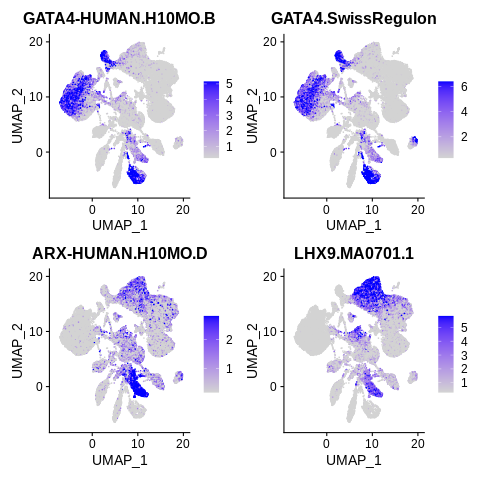

In [39]:
%%R 

FeaturePlot(
  object = ATAC_Seurat_withChromVar,
  features = c('GATA4-HUMAN.H10MO.B', 'GATA4.SwissRegulon', 
                  'ARX-HUMAN.H10MO.D',  
                 'LHX9.MA0701.1'
                  ),
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)

In [11]:
%%R -o chromvar_assay

chromvar_assay <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_Seurat_withChromVar))))

In [12]:
chromvar_assay.shape

(30276, 1920)

In [15]:
ATAC_scanpy

AnnData object with n_obs × n_vars = 30276 × 232562
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'Immune', 'Sertoli', 'Germ cells', 'Erythroid', 'Ti', 'FetalLeydig', 'Epithelial', 'M_MGP', 'Gi', 'PV', 'Endothelial', 'sPAX8', 'Sertoli_WFDC2', 'coelEpi', 'M_ALX1', 'Neural', 'M_prog_ISL1', 'sKITLG', 'sLGR5', 'max', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'sex

In [16]:
# Mapping of cells to cell types 
ATAC_scanpy.obs['barcode'] = ATAC_scanpy.obs_names
cells_celltypes = ATAC_scanpy.obs[['barcode', 'cell_type']]
cells_celltypes.head()

,barcode,cell_type
01-AAACGAAAGCTGAGGT-1,01-AAACGAAAGCTGAGGT-1,Sertoli
01-AAACGAACAATCATCG-1,01-AAACGAACAATCATCG-1,Sertoli
01-AAACTCGTCACCCGGA-1,01-AAACTCGTCACCCGGA-1,Sertoli
01-AAACTGCCAAGGGTAC-1,01-AAACTGCCAAGGGTAC-1,sPAX8
01-AAACTGCGTGAATGTA-1,01-AAACTGCGTGAATGTA-1,M_MGP


In [17]:
cells_mapping_clusters = cells_celltypes.groupby('cell_type').groups

In [18]:
# Mean by rows 
for key in cells_mapping_clusters: 
    print(key)
    chromvar_assay.loc[key] = chromvar_assay.loc[cells_mapping_clusters[key]].mean(axis = 0)

Germ cells
coelEpi
sPAX8
Sertoli
FetalLeydig
Ti
Gi
PV
M_MGP
M_prog_ISL1
Epithelial
Immune
Endothelial
Erythroid
Neural


In [19]:
rows_celltypes = list(np.unique(cells_celltypes['cell_type']))
print(rows_celltypes)
# Select only aggregated rows
chromvar_assay = chromvar_assay.loc[rows_celltypes, ]

['Endothelial', 'Epithelial', 'Erythroid', 'FetalLeydig', 'Germ cells', 'Gi', 'Immune', 'M_MGP', 'M_prog_ISL1', 'Neural', 'PV', 'Sertoli', 'Ti', 'coelEpi', 'sPAX8']


In [20]:
# Normalize by column (TF)
from scipy.stats import zscore
chromvar_assay_zscore = chromvar_assay.apply(zscore)

In [21]:
chromvar_assay_zscore.to_csv(outdir + experiment_prefix + "_chromvar_celltype_zscore.csv")

In [22]:
chromvar_assay_zscore = chromvar_assay_zscore.reindex(['Germ cells',
                                                 'coelEpi',  'sPAX8',  'Sertoli',
                                                 'FetalLeydig', 'Ti',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP',
                                                 'PV','Epithelial', 'Endothelial', 'Immune',  'Erythroid', 'Neural'
                         ])

In [23]:
import seaborn as sns
my_cmap = sns.diverging_palette(240, 10, n=9,s = 100, l = 40, as_cmap=True)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


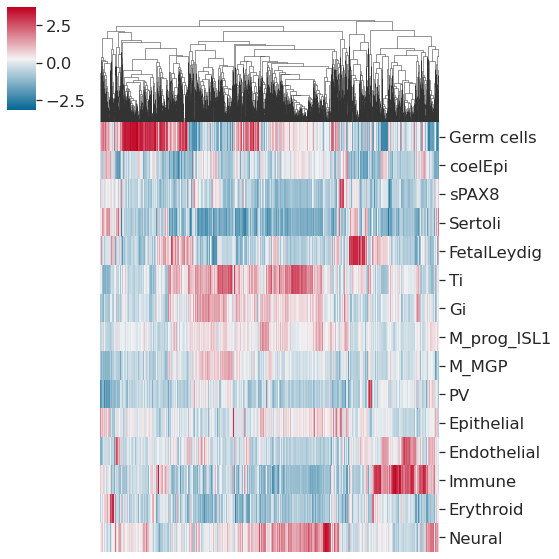

In [24]:
sns.set(font_scale=1.5)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore, row_cluster=False, annot=False, xticklabels = False, yticklabels = "auto",  figsize=(8, 8),
                         cmap = my_cmap)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_males/heatmap_males_TFs.pdf")

### Select top 3 TFs per cell type

In [25]:
top_tfs = []
for c in chromvar_assay_zscore.index:
    df_c = chromvar_assay_zscore.loc[c]
    df_c = df_c.sort_values(axis = 0, ascending = False)
    top_4 = df_c[0:4].index
    top_tfs.extend(top_4)

In [26]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore[top_tfs]

In [27]:
chromvar_assay_zscore_top4.columns

Index(['NFYB.MA0502.1', 'NFYC.SwissRegulon', 'NFYA.MA0060.3',
       'NFYB.SwissRegulon', 'HLF-HUMAN.H10MO.C', 'KLF7.SwissRegulon',
       'HLF.SwissRegulon', 'MESP1-HUMAN.H10MO.D', 'TCF7L2.SwissRegulon',
       'TCF7L2.MA0523.1', 'LEF1-HUMAN.H10MO.C', 'LEF1.SwissRegulon',
       'DMRT3.MA0610.1', 'DMRT6.HOMER', 'SOX2.SwissRegulon',
       'SOX10-HUMAN.H10MO.D', 'RORA-HUMAN.H10MO.B', 'RORG-HUMAN.H10MO.C',
       'RORC.SwissRegulon', 'NR4A1.MA1112.1', 'POU6F2.MA0793.1',
       'VSX1.MA0725.1', 'VSX2.MA0726.1', 'PDX1-HUMAN.H10MO.C',
       'ATF5.SwissRegulon', 'ZFP3.HOMER', 'ZNF675.HOMER', 'ZSCAN22.HOMER',
       'MEIS1-HUMAN.H10MO.C', 'HOXA9.SwissRegulon', 'HOXA9.HOMER',
       'HXA10-HUMAN.H10MO.C', 'GLI2-HUMAN.H10MO.B', 'HSF2-HUMAN.H10MO.A',
       'ZBTB18.MA0698.1', 'FIGLA.SwissRegulon', 'EBF1.MA0154.3',
       'MEF2D-HUMAN.H10MO.C', 'MEF2D.SwissRegulon', 'MEF2C.SwissRegulon',
       'HNF1B.MA0153.2', 'HNF1A.MA0046.2', 'SIX2.MA1119.1',
       'HNF1B.SwissRegulon', 'FLI1.SwissRegulon'

In [35]:
to_plot = ['NFYB.MA0502.1', 
       'HLF.SwissRegulon', 
        'PAX1.MA0779.1','DMRT3.MA0610.1',
           'RORC.SwissRegulon', 'VSX1.MA0725.1','ATF5.SwissRegulon','MEIS1-HUMAN.H10MO.C','HSF2-HUMAN.H10MO.A','EBF3.SwissRegulon',
            'HNF1B.MA0153.2', 'FLI1.SwissRegulon','SPI1.MA0080.4', 'GATA1-HUMAN.H10MO.A', 'PRRX1.SwissRegulon',
          ]
len(to_plot)

15

In [36]:
chromvar_assay_zscore_top4 = chromvar_assay_zscore[to_plot]

In [37]:
chromvar_assay_zscore_top4.columns = [col.split(".")[0] for col in chromvar_assay_zscore_top4.columns]

In [38]:
chromvar_assay_zscore_top4.columns = [col.split("-")[0] for col in chromvar_assay_zscore_top4.columns]

In [39]:
chromvar_assay_zscore.values.min()

-3.1885893058510644

In [40]:
import matplotlib
divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


<ipython-input-40-63a9665b3b7d>:2: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = matplotlib.colors.DivergingNorm(vmin=chromvar_assay_zscore.values.min(), vcenter=0, vmax=chromvar_assay_zscore.values.max())


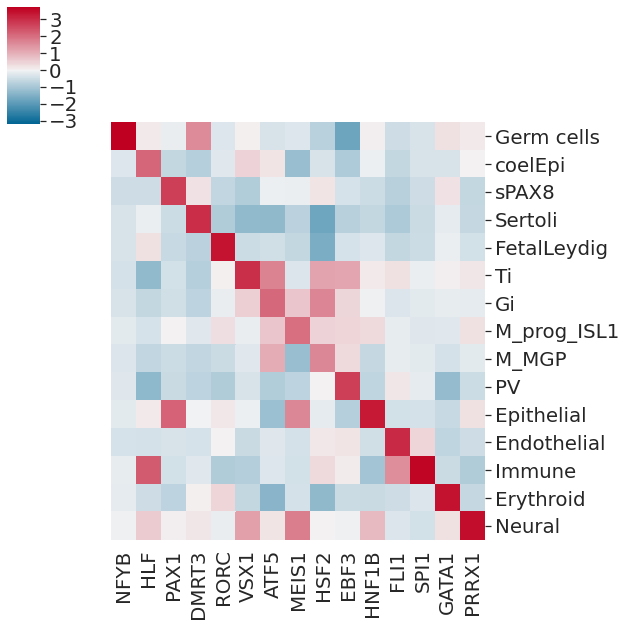

In [41]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_top4, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(9,9),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_males/heatmap_males_TFs_top1_curated.pdf")

In [114]:
### Leydig cells TFs: 
leydig = chromvar_assay_zscore.loc["FetalLeydig"]
leydig = leydig.sort_values(axis = 0, ascending = False)
leydig_19 = leydig[0:20].index

In [115]:
leydig_19

Index(['RORA-HUMAN.H10MO.B', 'RORG-HUMAN.H10MO.C', 'RORC.SwissRegulon',
       'NR4A1.MA1112.1', 'NR6A1.SwissRegulon', 'NR6A1-HUMAN.H10MO.B',
       'RARB-HUMAN.H10MO.D', 'RORA.MA0071.1', 'HNF4G-HUMAN.H10MO.C',
       'NR1H2-HUMAN.H10MO.D', 'NKX2-8.SwissRegulon', 'RARA.MA0729.1',
       'RORA.SwissRegulon', 'NR2C2-HUMAN.H10MO.A', 'PPARA-HUMAN.H10MO.S',
       'PPARA.SwissRegulon', 'NR2F2.MA1111.1', 'NR2F1.MA0017.2',
       'ESRRB.SwissRegulon', 'ESRRA.SwissRegulon'],
      dtype='object')

In [49]:
dsd_tfs = ['ARX', 'ATRX', 'BMP15', 'CBX2', 'DAX1', 'DHH', 'DHX37', 'DMRT1', 'EMX2', 'ESR2', 'FGF9', 'FGFR2', 'FOXL2',
          'GATA4', 'HHAT', 'MAP3K1', 'NR2F2', 'NR5A1', 'NUP107', 'RSPO1', 'SOX3', 'SOX8', 'SOX9', 'SOX10', 'SRY', 
          'STARD8', 'TSPYL1', 'WNT4', 'WT1', 'WWOX', 'ZFPM2', 'ZNRF3']

In [50]:
df = pd.DataFrame(chromvar_assay_zscore.columns)

In [51]:
df[0][df[0].str.contains('|'.join(dsd_tfs))]

14            SOX9.MA0077.1
16             SRY.MA0084.1
62            ESR2.MA0258.2
338           SOX8.MA0868.1
343          BARX1.MA0875.1
348           EMX2.MA0886.1
393          NR2F2.MA1111.1
404          SOX10.MA0442.2
467       ARX-HUMAN.H10MO.D
478     BARX1-HUMAN.H10MO.D
479     BARX2-HUMAN.H10MO.D
561      EMX2-HUMAN.H10MO.D
571      ESR2-HUMAN.H10MO.A
572      ESR2-HUMAN.H10MO.S
627     GATA4-HUMAN.H10MO.B
958     SOX10-HUMAN.H10MO.D
967      SOX3-HUMAN.H10MO.D
971      SOX8-HUMAN.H10MO.D
972      SOX9-HUMAN.H10MO.B
986       SRY-HUMAN.H10MO.B
1049      WT1-HUMAN.H10MO.D
1102       ARX.SwissRegulon
1116     BARX1.SwissRegulon
1117     BARX2.SwissRegulon
1199      EMX2.SwissRegulon
1208      ESR2.SwissRegulon
1265     GATA4.SwissRegulon
1502     NR2F2.SwissRegulon
1624     SOX10.SwissRegulon
1635     SOX30.SwissRegulon
1636      SOX3.SwissRegulon
1641      SOX8.SwissRegulon
1642      SOX9.SwissRegulon
1656       SRY.SwissRegulon
1724       WT1.SwissRegulon
1791            DMRT

In [ ]:
dsd_tfs_present = ['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon', 'ESR2.SwissRegulon',
                  'GATA4.SwissRegulon', 'FOXL2.HOMER',
                  'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 
                   'SOX8-HUMAN.H10MO.D', 'SOX9.SwissRegulon', 
                  'SOX10.SwissRegulon', 'SRY.SwissRegulon', 'SRY-HUMAN.H10MO.B',
                  'WT1-HUMAN.H10MO.D']

In [60]:
chromvar_assay_zscore_DSD = chromvar_assay_zscore[dsd_tfs_present]
chromvar_assay_zscore_DSD.columns

Index(['ARX.SwissRegulon', 'DMRT1.HOMER', 'EMX2.SwissRegulon',
       'ESR2.SwissRegulon', 'GATA4.SwissRegulon', 'FOXL2.HOMER',
       'NR2F2.MA1111.1', 'SOX3.SwissRegulon', 'SOX8-HUMAN.H10MO.D',
       'SOX9.SwissRegulon', 'SOX10.SwissRegulon', 'SRY.SwissRegulon',
       'WT1-HUMAN.H10MO.D'],
      dtype='object')

In [61]:
chromvar_assay_zscore_DSD.columns = [col.split(".")[0] for col in chromvar_assay_zscore_DSD.columns]
chromvar_assay_zscore_DSD.columns = [col.split("-")[0] for col in chromvar_assay_zscore_DSD.columns]


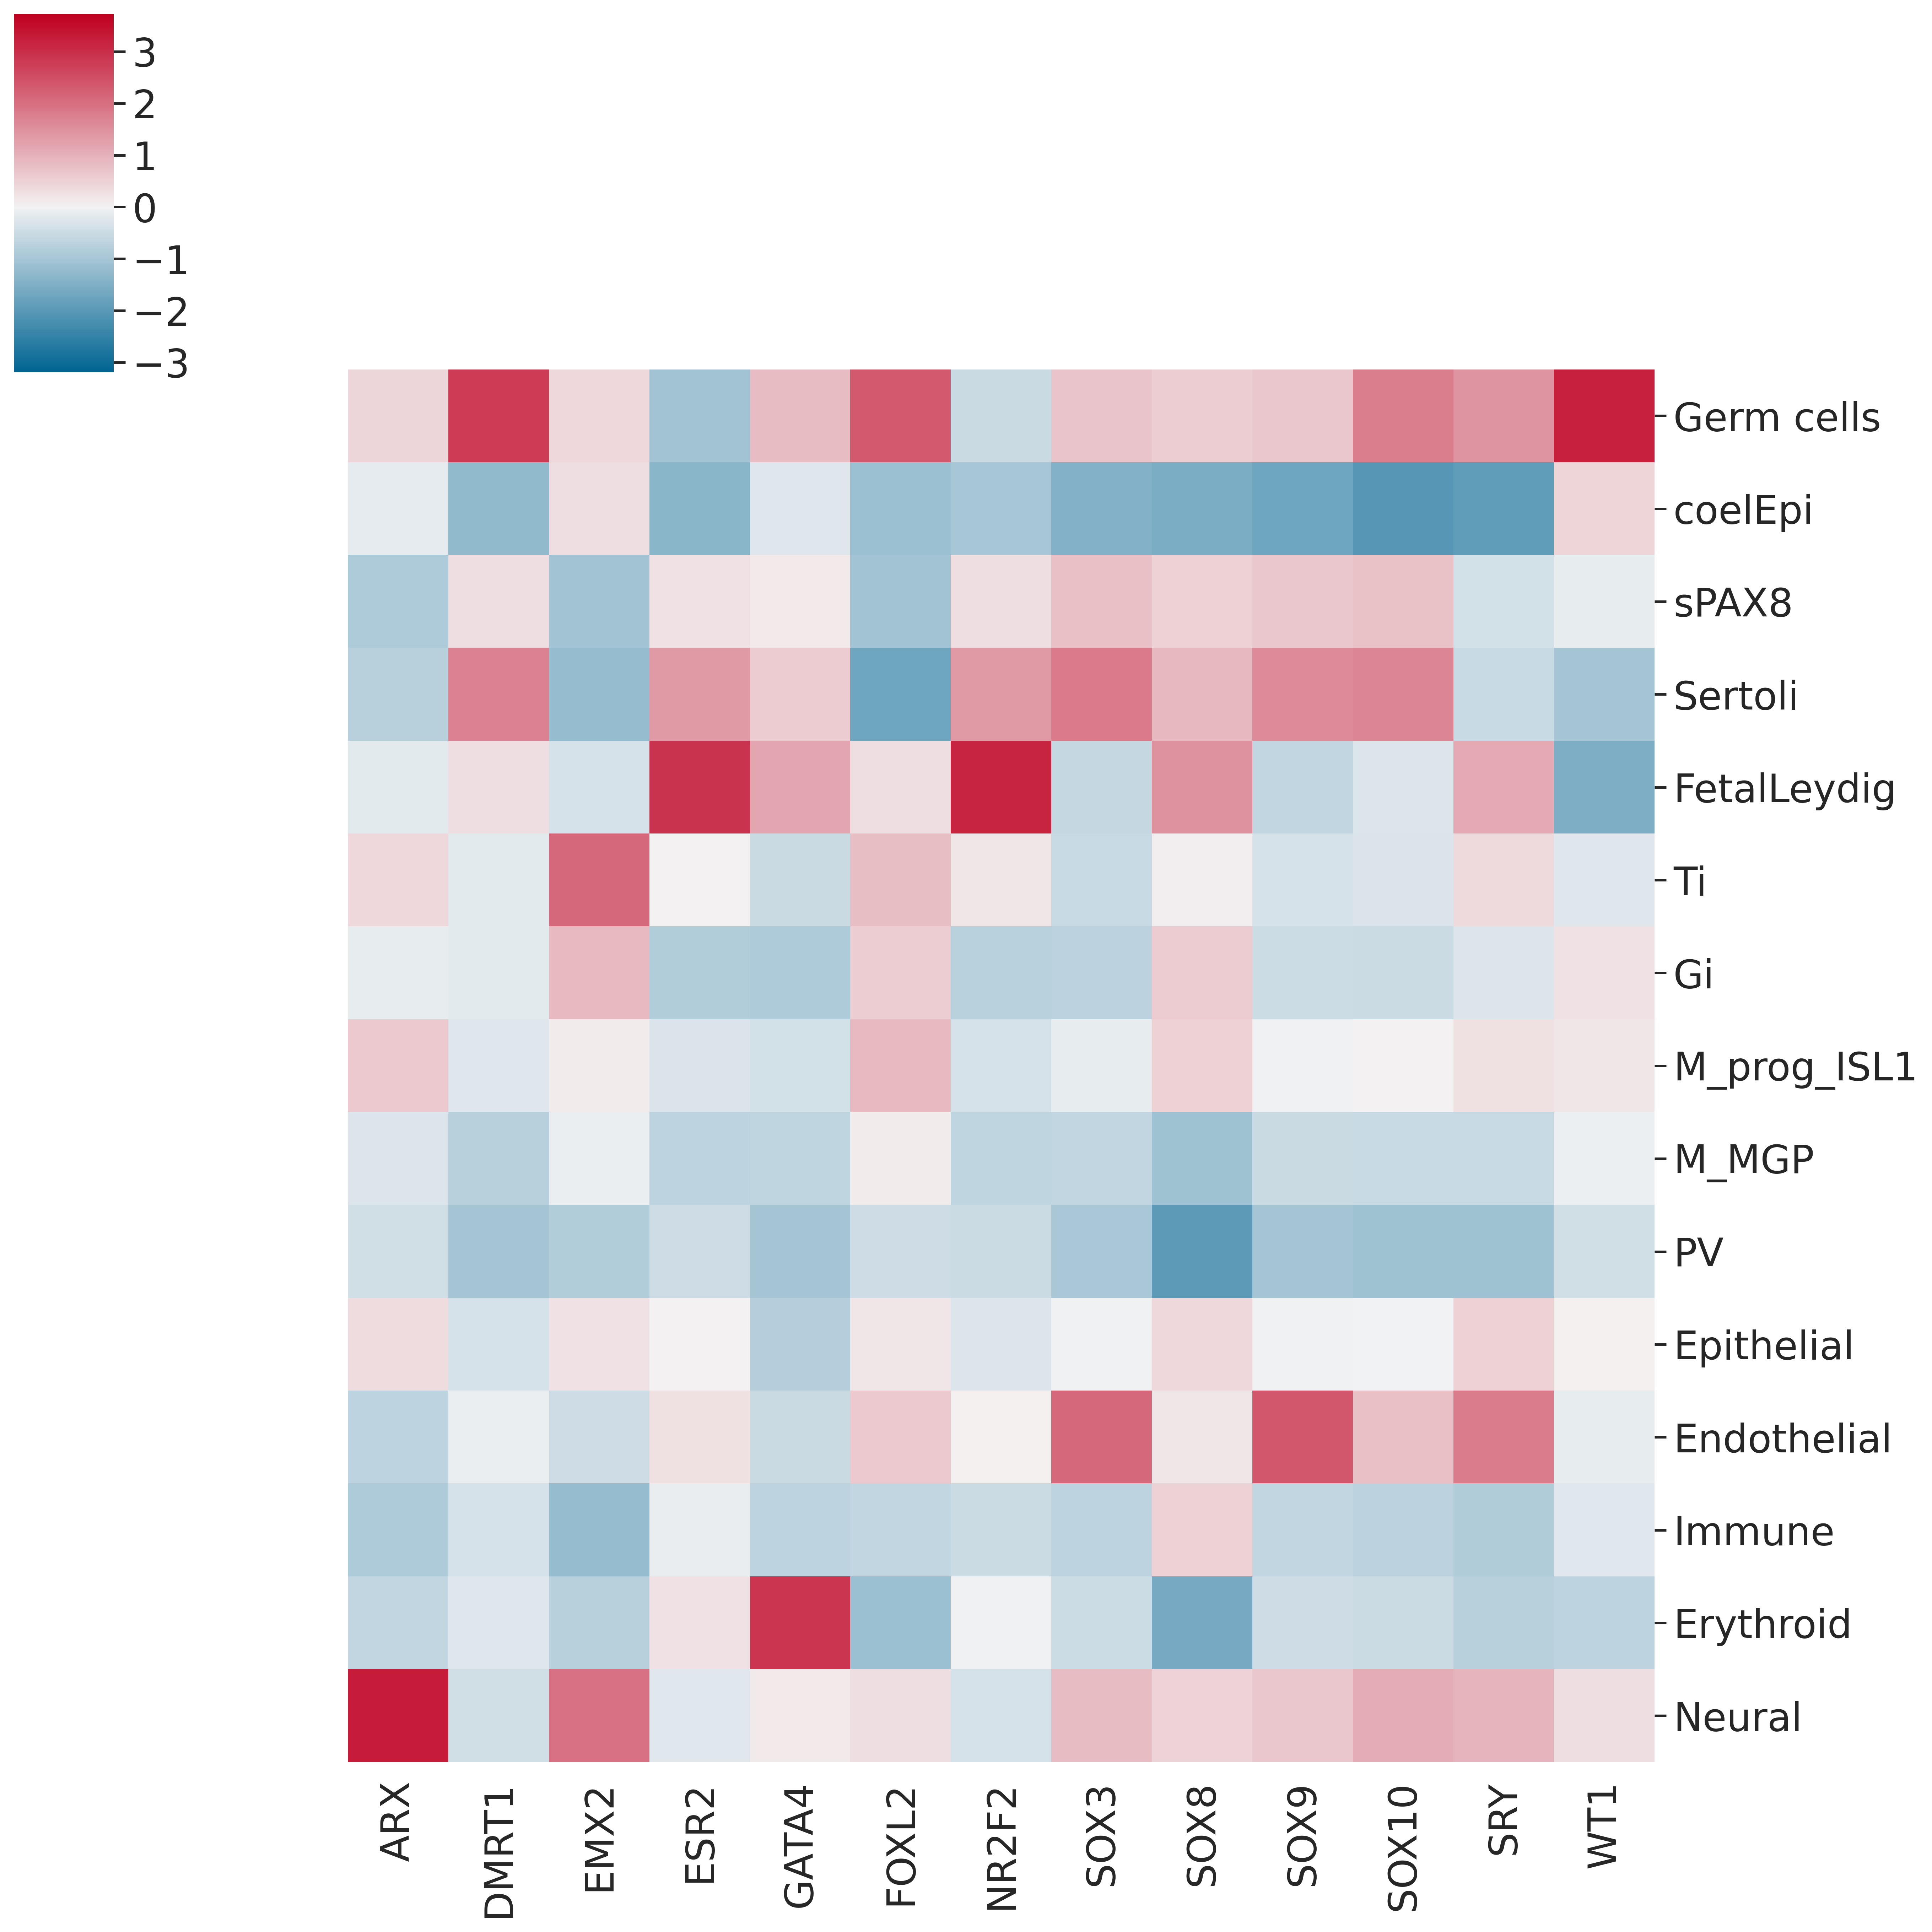

In [62]:
sns.set(font_scale=1.8)
heatmap_TFs = sns.clustermap(chromvar_assay_zscore_DSD, row_cluster=False, col_cluster = False, annot=False, xticklabels = True, yticklabels = "auto",  figsize=(14, 14),
                         cmap = my_cmap, norm=divnorm)
heatmap_TFs.savefig("/home/jovyan/MULTIOME_april2021/figures_males/DSD_TFs_heatmap.pdf")


#### End of notebook